_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*Agnese Adorante, Hwajin Shin, Lucia Gonzalez Anton* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

In [2]:
# from google.colab import drive

# drive.mount("/content/drive", force_remount=True)

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [1]:
# import packages here

import os
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.cm as cm
import random


%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-07-13 19:57:36ora legale Europa occidentale

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 9.4.0

sklearn: not installed

scipy     : 1.13.1
pandas    : 2.2.3
numpy     : 1.26.4
matplotlib: 3.10.0

Watermark: 2.5.0



## Context

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.


The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of the recorded area
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [2]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_rf.npz", allow_pickle=True)
    data = dict(data)
    array2df(data, "stim_table", ["frame", "start", "end"])
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


path = os.getcwd()
data = load_data(path)

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



## Question

**Is there spatial structure on the location of the receptive fields?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of:
1. Pre-processing
2. Spike inference
3. Tuning function fitting
4. Statistical testing.

It is sufficient to assess spatial structure visually. Additional insights and analyses will be positively factored into the overall grade.

# Utils

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors


def plot_trace_with_stimulus(
    trace,
    time,
    stim_epochs,
    start_time,
    duration,
    event_trace=None,
    fs=30,
    colormap="tab10",
    behavior=False,
):
    """
    Plots a single calcium trace with vertical background shading for each stimulus type.

    Parameters:
        trace (np.ndarray): dF/F trace of one neuron
        time (np.ndarray): time vector
        stim_epochs (pd.DataFrame): with columns ['stimulus', 'start', 'end']
        start_time (float): time to start plotting (in seconds)
        duration (float): duration to plot (in seconds)
        event_trace (np.ndarray): optional, e.g. deconvolved spikes
        fs (int): sampling rate
        colormap (str): name of matplotlib colormap
    """

    # Set time window
    start_frame = int(start_time * fs)
    end_frame = int((start_time + duration) * fs)
    time_window = time[start_frame:end_frame]
    trace_window = trace[start_frame:end_frame]
    if event_trace is not None:
        event_window = event_trace[start_frame:end_frame]

    # Create stimulus colormap
    stim_types = sorted(stim_epochs["stimulus"].unique())
    colors = cm.get_cmap(colormap, len(stim_types))
    stim_color_map = {stim: colors(i) for i, stim in enumerate(stim_types)}

    # Plot
    plt.figure(figsize=(15, 4))

    # Background shading
    for _, row in stim_epochs.iterrows():
        stim_start, stim_end = row["start"], row["end"]
        stim_label = row["stimulus"]
        if (stim_end / fs) < start_time or (stim_start / fs) > (start_time + duration):
            continue  # outside window

        # Clamp shading to plotting window
        plot_start = max(stim_start / fs, start_time)
        plot_end = min(stim_end / fs, start_time + duration)

        plt.axvspan(plot_start, plot_end, color=stim_color_map[stim_label], alpha=0.2)

    # Plot traces
    plt.plot(
        time_window,
        trace_window / trace_window.max(),
        label="dff trace",
        color="steelblue",
    )
    if event_trace is not None:
        plt.plot(time_window, event_window, label="events trace", color="orange")

    if behavior is True:
        plt.plot(
            time_window,
            running_speed[0, start_frame:end_frame]
            / running_speed[0, start_frame:end_frame].max(),
            label="running speed",
            color="green",
        )
    # Legend for stimulus types
    legend_patches = [
        mpatches.Patch(color=stim_color_map[stim], label=stim) for stim in stim_types
    ]
    event_patchs = [plt.Line2D([], [], color="steelblue", label="dff trace")]
    if event_trace is not None:
        event_patchs.append(plt.Line2D([], [], color="orange", label="events trace"))
    if behavior is True:
        event_patchs.append(plt.Line2D([], [], color="green", label="running speed"))
    plt.legend(handles=legend_patches + event_patchs)

    plt.xlabel("Time (s)")
    plt.ylabel("Normalized response magnitude")
    plt.title(f"Calcium Trace with Stimulus Background")
    plt.tight_layout()
    plt.show()

In [4]:
def plot_calcium_traces(indices, start_time, duration, fs=30, offset=3):
    """
    Plot calcium traces for selected neuron indices within a time window.

    Parameters:
        indices (list): List of neuron indices to plot
        start_time (float): Start time in seconds
        duration (float): Duration in seconds
        fs (int): Sampling rate (frames per second)
        offset (float): Vertical offset between traces
        time (np.ndarray): Time vector
        traces (np.ndarray): Calcium trace array (neurons x time)
    """
    time = data["t"]
    traces = data["dff"]

    # Convert time window to frame indices
    start_frame = int(start_time * fs)
    end_frame = int((start_time + duration) * fs)

    # Extract time and trace segments
    time_window = time[start_frame:end_frame]
    trace_window = traces[:, start_frame:end_frame]

    # Plot
    plt.figure(figsize=(12, 6))
    for i, neuron_idx in enumerate(indices):
        trace = trace_window[neuron_idx]
        trace_norm = trace / trace.max()  # normalize
        plt.plot(time_window, trace_norm + i * offset, color="black")

    plt.title(f"Normalized Calcium Traces")
    plt.xlabel("Time (s)")
    plt.yticks(np.arange(len(indices)) * offset, indices)
    plt.ylabel("Neuron ID")
    plt.tight_layout()
    plt.show()

# Exploratory Data Analysis

In [3]:
# Clacium trace
traces = data["dff"]  # shape: (n_cells, n_frames)

# Stimuli
stim_epochs = data["stim_epoch_table"]
stim_epochs.columns = ["stimulus", "start", "end"]
stim_metadata = data["stim_table"]
stims = data["stim"]

# Roi masks and projections
roi_masks = data["roi_masks"]
max_projection = data["max_projection"]

# Behavior
running_speed = data["running_speed"]

# time
time = data["t"]

In [6]:
print("Traces Info")
print(f"Number of cells: {traces.shape[0]}")
print(f"Number of frames: {traces.shape[1]}")
print("---------------------------------------------------")
print("Stimulus Info")
print(f"Number of stimulus epochs: {len(stim_epochs)}")
print(f"Stimuli types: {set(stim_epochs['stimulus'])}")
print(f"Number of presented stimuli: {stim_metadata.shape[0]}")
print(f"Stimulus shape: {stims.shape[1], stims.shape[2]}")
print("---------------------------------------------------")
print("Recording Frequency")
diff = np.diff(time)
frequency = 1 / diff.mean()
print(f"Time resolution: {np.round(frequency)} Hz")
print("---------------------------------------------------")
print("ROI Masks Info")
print(f"Max projection shape: {max_projection.shape}")
print(f"Number of ROIs: {roi_masks.shape[0]}")

Traces Info
Number of cells: 189
Number of frames: 105968
---------------------------------------------------
Stimulus Info
Number of stimulus epochs: 7
Stimuli types: {'natural_movie_two', 'spontaneous', 'locally_sparse_noise', 'natural_movie_one'}
Number of presented stimuli: 8880
Stimulus shape: (16, 28)
---------------------------------------------------
Recording Frequency
Time resolution: 30.0 Hz
---------------------------------------------------
ROI Masks Info
Max projection shape: (512, 512)
Number of ROIs: 189


In [7]:
stim_epochs

,stimulus,start,end
0,locally_sparse_noise,737,22461
1,spontaneous,22611,31520
2,natural_movie_one,31521,40571
3,locally_sparse_noise,41476,63199
4,natural_movie_two,64105,73156
5,spontaneous,73306,82207
6,locally_sparse_noise,82208,105742


## Calcium Trace

Text(0, 0.5, 'Neurons')

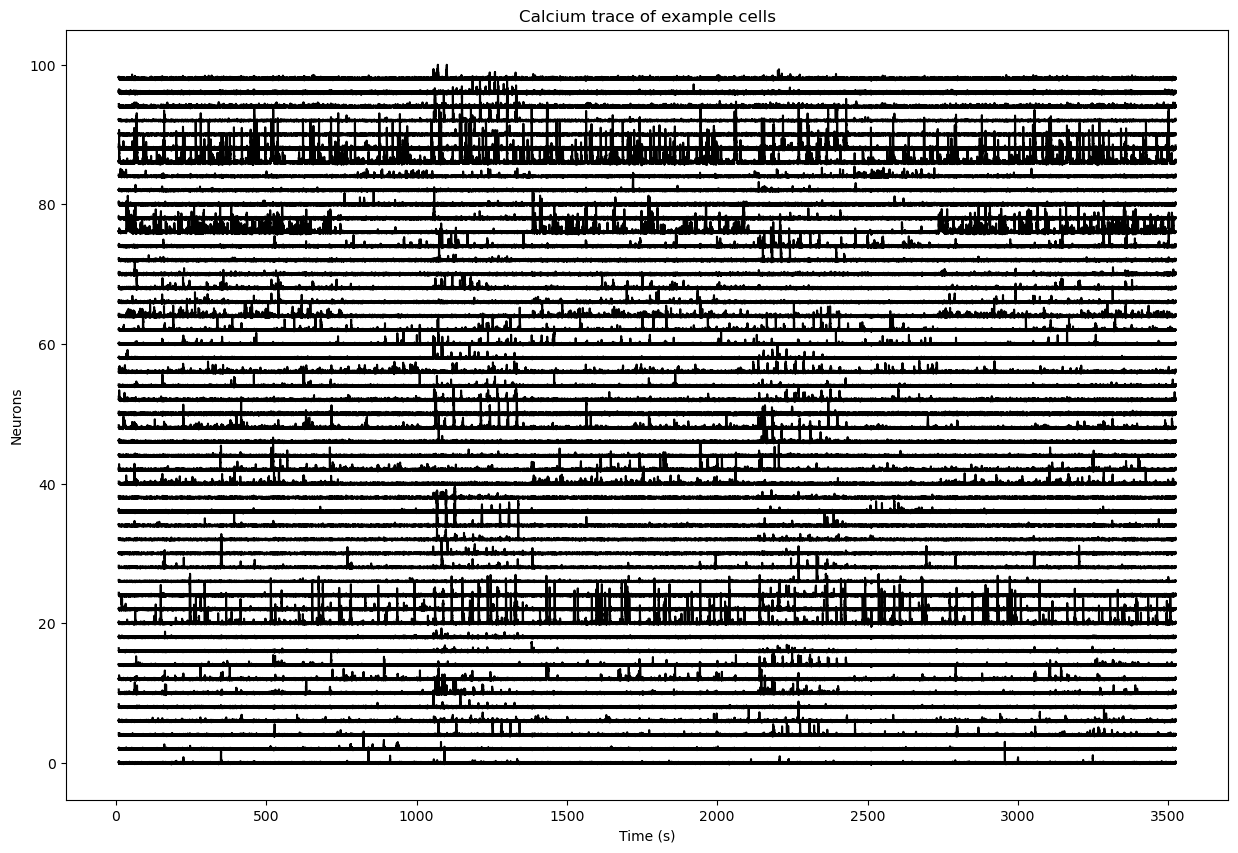

In [10]:
fig = plt.figure(figsize=(15, 10))
for i in range(50):
    plt.plot(time, traces[i, :] + (i * 2), color="black")
plt.title("Calcium trace of example cells")
plt.xlabel("Time (s)")
plt.ylabel("Neurons")

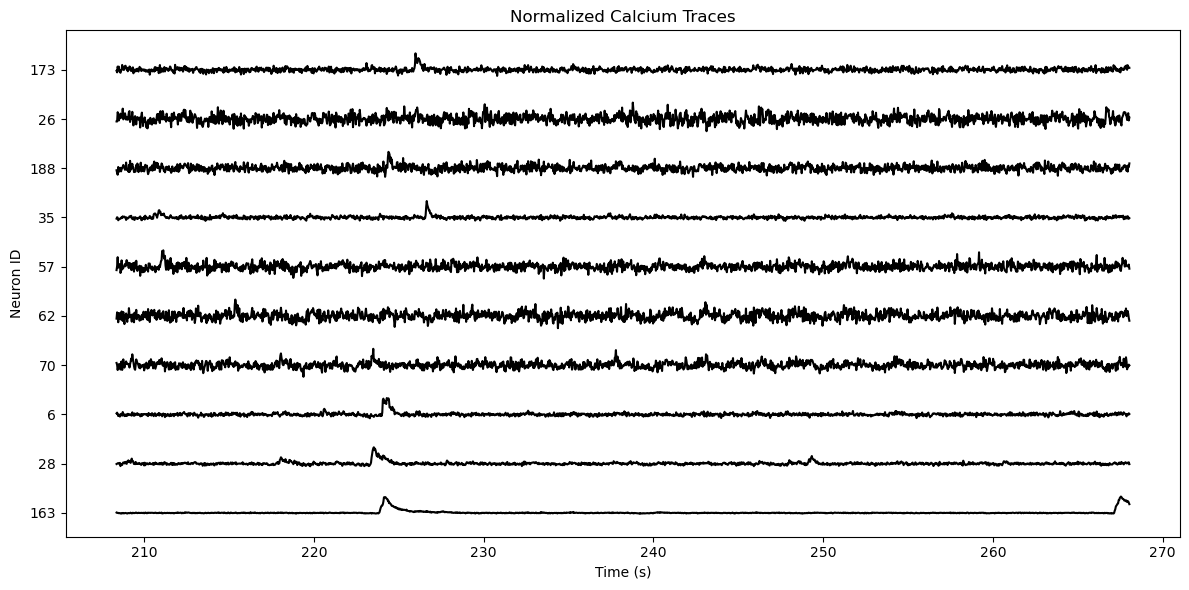

In [11]:
random.seed(42)
indices = random.sample(range(traces.shape[0]), 10)

plot_calcium_traces(indices, start_time=200, duration=60)

C:\Users\34600\AppData\Local\Temp\ipykernel_16972\3016076656.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(colormap, len(stim_types))


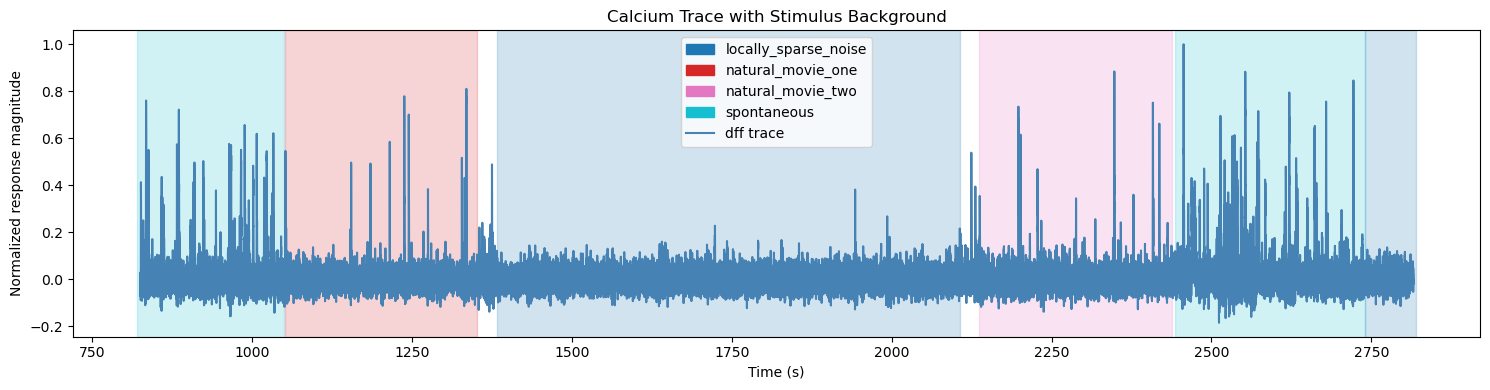

In [12]:
# Choose neuron index and time window
neuron_idx = 42
start_time = 820
duration = 2000

# Use your data
trace = traces[neuron_idx]

# Call function (without events)
plot_trace_with_stimulus(trace, time, stim_epochs, start_time, duration)

C:\Users\34600\AppData\Local\Temp\ipykernel_16972\3016076656.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(colormap, len(stim_types))


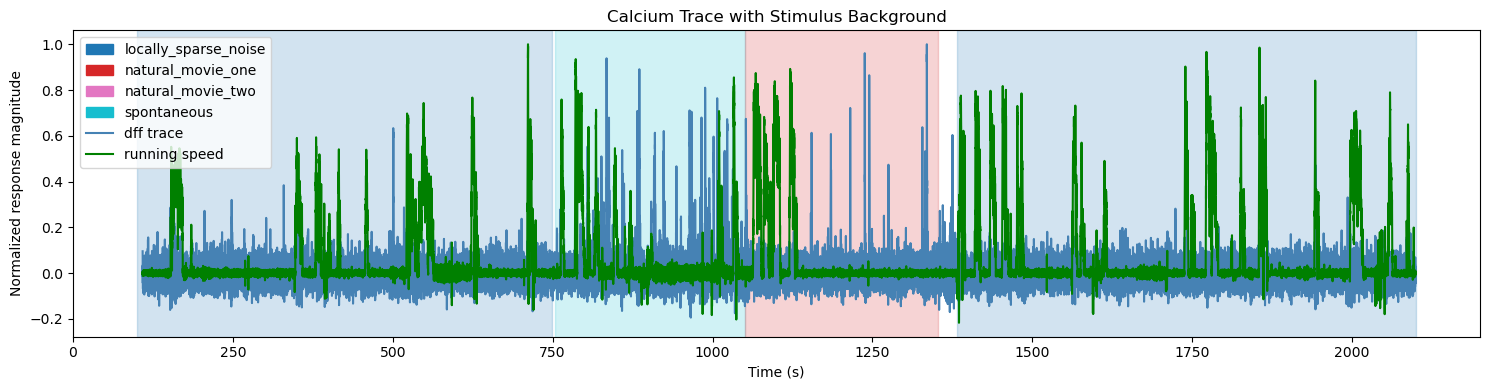

In [13]:
neuron_idx = 42
start_time = 100
duration = 2000

# Use your data
trace = traces[neuron_idx]

# Call function (without events)
plot_trace_with_stimulus(trace, time, stim_epochs, start_time, duration, behavior=True)

C:\Users\34600\AppData\Local\Temp\ipykernel_16972\3016076656.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(colormap, len(stim_types))


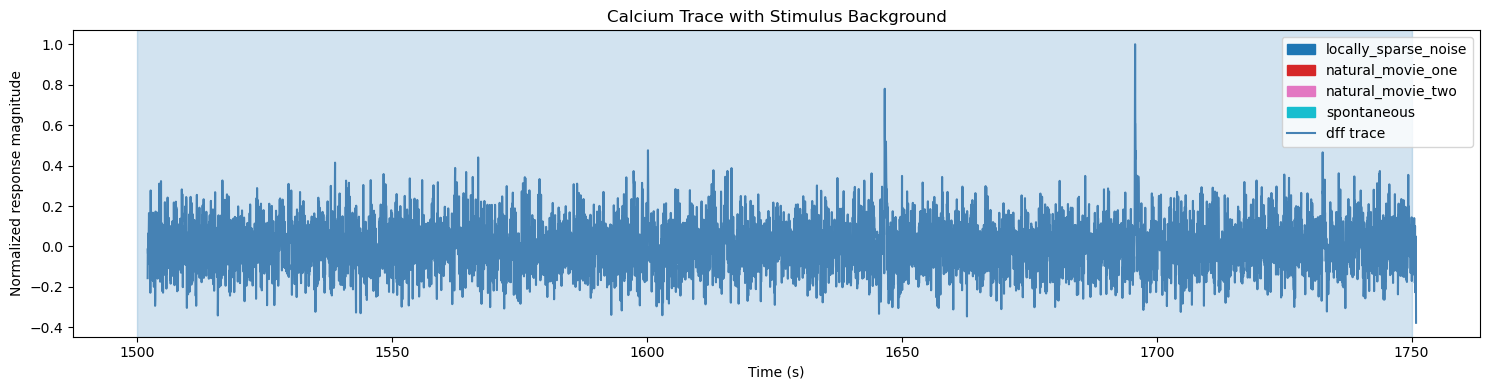

In [14]:
neuron_idx = 11
start_time = 1500
duration = 250

# Use your data
trace = traces[neuron_idx]

# Call function (without events)
plot_trace_with_stimulus(trace, time, stim_epochs, start_time, duration)

## Stimulus

**Locally Sparse Noise**

The locally sparse noise stimulus consists of black and white spots flashed on the monitor. For each frame of the stimulus a small number of pixels were white and a small number were black, while the rest were mean luminance gray. The white and black spots were distributed such that no two spots were within 5 pixels of each other. Each time a given pixel was occupied by a black (or white) spot, there was a different array of other pixels occupied by either black or white spots. As a result, when all of the frames when that pixel was occupied by the black spot were averaged together, there was no significant structure surrounding the specified pixel. Further, the stimulus was well balanced with regards to the contrast of the pixels, such that while there was a slightly higher probability of a pixel being occupied just outside of the 5-pixel exclusion zone, the probability was equal for pixels of both contrast. Each pixel was occupied by either a white or black spot a variable number of times. Typically, each frame we presented for 0.25 seconds and followed immediately by the next trial without any intertrial interval. There are no blanksweeps.

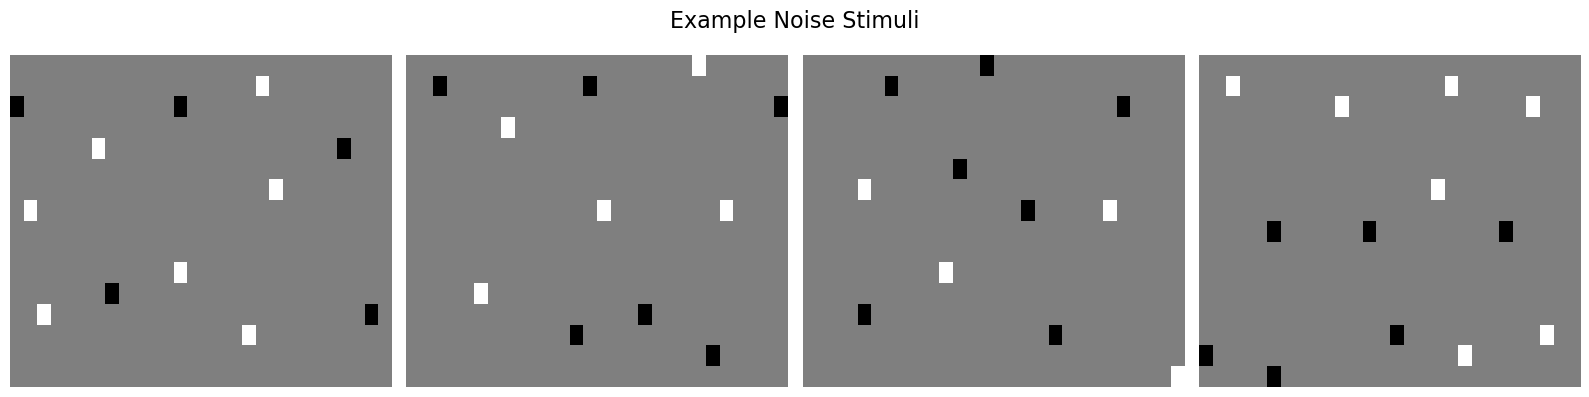

In [15]:
# Filter stim_epochs for only locally_sparse_noise
lsn_epochs = stim_epochs[stim_epochs["stimulus"] == "locally_sparse_noise"]

# Get all frames within those epochs
lsn_frame_idxs = []
for _, row in lsn_epochs.iterrows():
    start, end = row["start"], row["end"]
    matching_frames = stim_metadata[
        (stim_metadata["start"] >= start) & (stim_metadata["end"] <= end)
    ]
    lsn_frame_idxs.extend(matching_frames["frame"].values)

lsn_frame_idxs = np.array(lsn_frame_idxs)
n = len(lsn_frame_idxs)

# Pick 4 evenly spaced frame indices
example_indices = np.linspace(0, n - 1, 4, dtype=int)
example_frames = [stims[lsn_frame_idxs[i]] for i in example_indices]

# Plot them
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axs[i].imshow(example_frames[i], cmap="grey", aspect="auto")
    axs[i].axis("off")

plt.suptitle("Example Noise Stimuli", fontsize=16)
plt.tight_layout()
plt.show()

In [16]:
np.unique(stims[0])

array([  0, 127, 255], dtype=uint8)

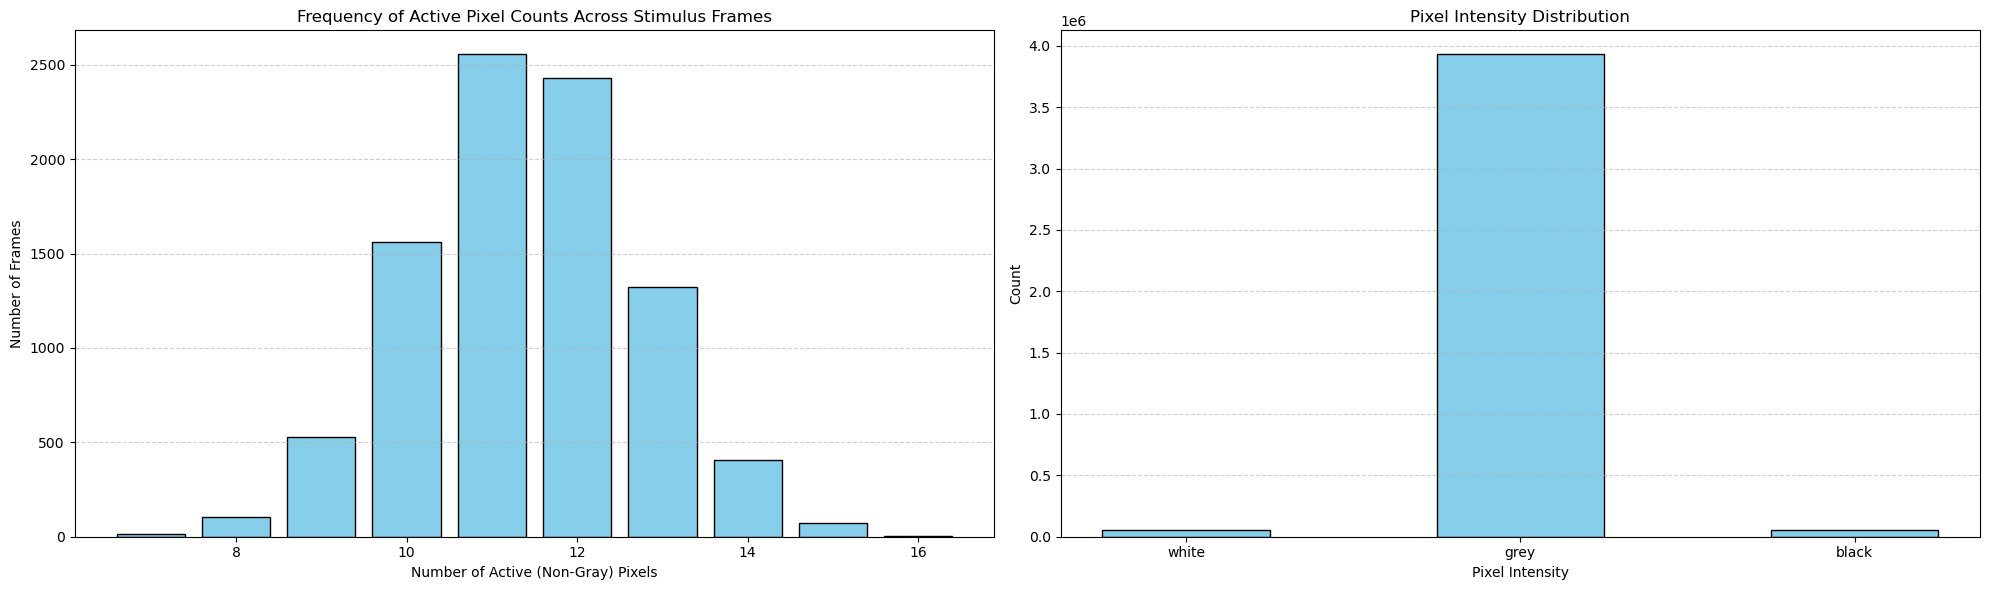

In [17]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Subplot 1: Frequency of Active Pixel Counts (Bar Plot)
gray_value = 127
non_gray_counts = np.sum(stims != gray_value, axis=(1, 2))
unique_counts, counts_frequency = np.unique(non_gray_counts, return_counts=True)

axs[0].bar(unique_counts, counts_frequency, color="skyblue", edgecolor="black")
axs[0].set_title("Frequency of Active Pixel Counts Across Stimulus Frames")
axs[0].set_xlabel("Number of Active (Non-Gray) Pixels")
axs[0].set_ylabel("Number of Frames")
axs[0].grid(axis="y", linestyle="--", alpha=0.6)

# Subplot 2: Pixel Intensity Distribution (Only 0, 127, 255)
intensity_labels = ["white", "grey", "black"]
intensity_values = [0, 127, 255]
intensity_counts = [np.sum(stims == val) for val in intensity_values]

axs[1].bar(
    [str(i) for i in intensity_labels],
    intensity_counts,
    color="skyblue",
    edgecolor="black",
    width=0.5,
)
axs[1].set_title("Pixel Intensity Distribution")
axs[1].set_xlabel("Pixel Intensity")
axs[1].set_ylabel("Count")
axs[1].grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

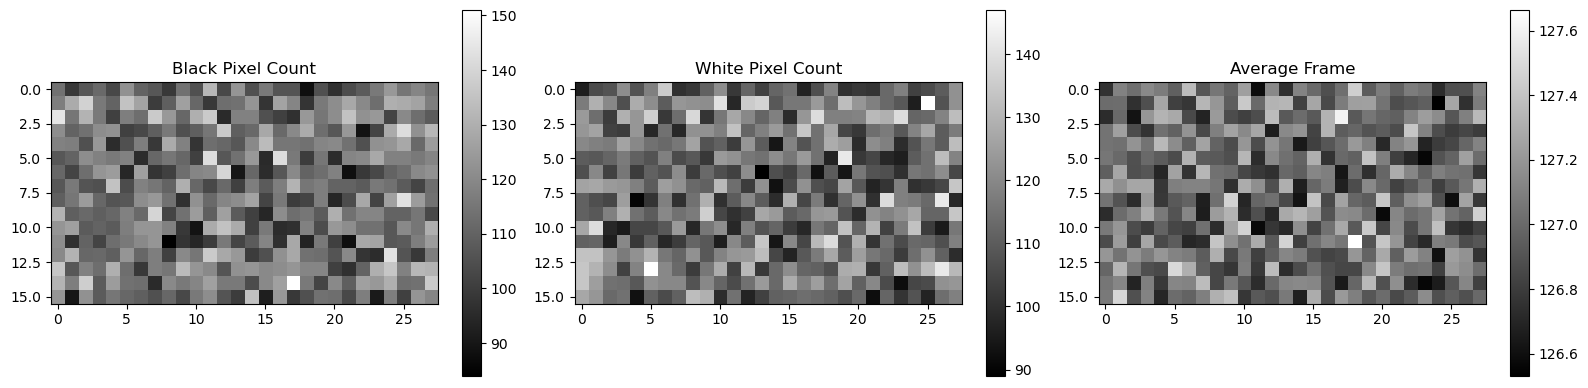

In [18]:
black_count = np.sum(stims == 0, axis=0)
white_count = np.sum(stims == 255, axis=0)
avg_frame = np.mean(stims, axis=0)

plt.figure(figsize=(16, 4))  # Adjust figure size for 1 row, 3 columns

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
plt.imshow(black_count, cmap="gray")
plt.title("Black Pixel Count")
plt.colorbar()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
plt.imshow(white_count, cmap="gray")
plt.title("White Pixel Count")
plt.colorbar()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
plt.imshow(avg_frame, cmap="gray")
plt.title("Average Frame")
plt.colorbar()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## ROi and max proj

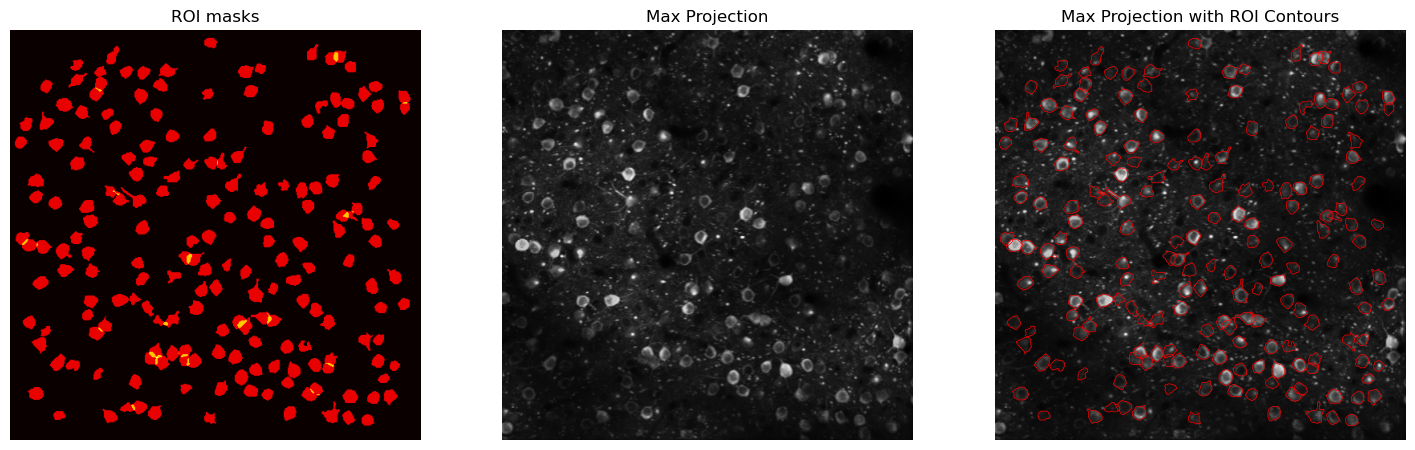

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 10))
# roi masks: all of the segmented masks for cell bodies in this experiment.
ax[0].imshow(roi_masks.sum(axis=0), cmap="hot")
ax[0].set_title("ROI masks")
ax[0].axis("off")
# max projection: the projection of the full motion corrected movie for all of the cells imaged during the session.
ax[1].imshow(max_projection, cmap="grey")
ax[1].set_title("Max Projection")
ax[1].axis("off")
# max projection with ROI
ax[2].imshow(max_projection, cmap="gray")
ax[2].set_title("Max Projection with ROI Contours")
for roi in roi_masks:
    ax[2].contour(roi, levels=[0.5], colors="r", linewidths=0.5)
ax[2].axis("off")

(-0.5, 24.5, 24.5, -0.5)

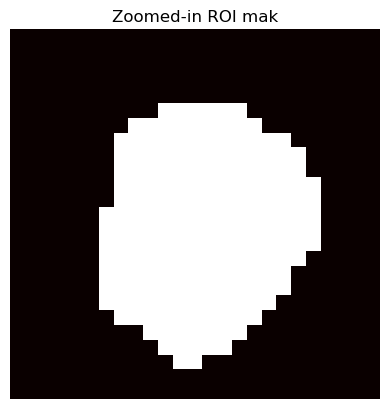

In [20]:
plt.imshow(roi_masks[0, 55:80, 100:125], cmap="hot")
plt.title("Zoomed-in ROI mak")
plt.axis("off")

# Pre-processing

In [5]:
activity_trace = data["dff"]  # shape (n_neurons,time)

In [4]:
# nice visualization of traces
# Determine sampling rate
dt = np.median(np.diff(time))  # sampling interval in seconds
fs = 1 / dt  # sampling frequency in Hz
print(fs)

30.14772384670897


In [6]:
# cutoff and fs and order can be manipulated
def lowpass_filter(trace, cutoff=0.7, fs=fs, order=3):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    filtered_trace = np.zeros_like(trace)
    b, a = signal.butter(order, norm_cutoff, btype="low", analog=False)
    neuron = signal.filtfilt(b, a, trace)

    return neuron


filtered_trace = lowpass_filter(activity_trace)

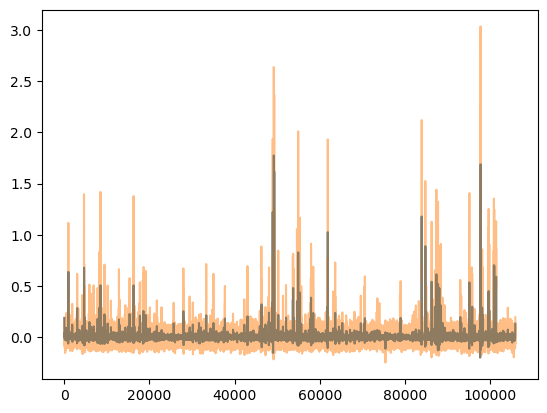

In [24]:
plt.plot(filtered_trace[100, :])
plt.plot(activity_trace[100, :], alpha=0.5)

# Events Extraction (Spike extraction)

In [7]:
# Simple threshold-based method

from scipy.signal import find_peaks
from scipy.stats import zscore

# threshold

N = 2

# Compute z score from scipy library
normalized_trace = zscore(filtered_trace, axis=1)


def detect_spikes_single_neuron(
    trace: np.ndarray, fs: float, N: int = N, lockout: float = 0.25
):
    """
    Detect spikes in a 1D calcium signal using a robust threshold and refractory period.

    Parameters:
        trace: 1D np.array, calcium trace for one neuron
        fs: float, sampling rate in Hz (e.g. 30)
        N: threshold multiplier (e.g. 5)
        lockout: refractory period in seconds (e.g. 0.001 = 1 ms)

    Returns:
        spike_idxs: indices of detected spikes
        spike_times: times of spikes in seconds
        threshold: computed threshold
    """
    # Compute robust standard deviation
    # sigma = np.median(np.abs(trace - np.median(trace)) / 0.6745)
    threshold = N

    # Use upward peaks over +threshold (for calcium), so flip sign if needed
    spike_idxs, _ = find_peaks(
        trace, height=threshold, distance=max(1, int(lockout * fs))
    )

    spike_times = spike_idxs / fs
    return spike_idxs, spike_times, threshold


# Apply to all neurons


def run_detect_spikes_all_neurons(data, fs=fs, N=N, lockout=0.25):
    spike_events = []

    for neuron_id in range(data.shape[0]):
        spike_idxs, spike_times, threshold = detect_spikes_single_neuron(
            data[neuron_id], fs=fs, N=N, lockout=lockout
        )
        for t_idx, t in zip(spike_idxs, spike_times):
            spike_events.append({"Neuron": neuron_id, "TimeIdx": t_idx, "Time": t})

    return pd.DataFrame(spike_events)


spikes_custom = run_detect_spikes_all_neurons(
    normalized_trace, fs=fs, N=N, lockout=0.25
)
print(spikes_custom.head())

   Neuron  TimeIdx       Time
0       0     6497  215.50549
1       0    10256  340.19152
2       0    13521  448.49157
3       0    25040  830.57680
4       0    27208  902.48936


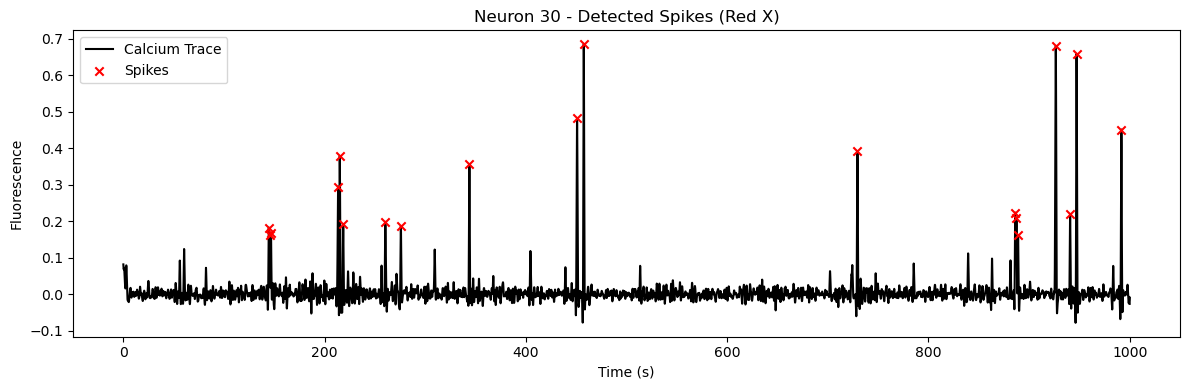

In [8]:
def plot_detected_spikes(trace, spike_idxs, fs=30, neuron_id="neuron_id", window=None):
    """
    Plot the calcium trace with detected spikes shown as red crosses.

    Parameters:
        trace: 1D np.array, calcium trace of one neuron
        spike_idxs: list or np.array of spike indices
        fs: sampling rate in Hz
        neuron_id: int, for labeling
        window: tuple (start_time, end_time) in seconds (optional)
    """
    t = np.arange(len(trace)) / fs

    if window:
        start, end = window
        idx_start = int(start * fs)
        idx_end = int(end * fs)
        t = t[idx_start:idx_end]
        trace = trace[idx_start:idx_end]
        spike_idxs = (
            spike_idxs[(spike_idxs >= idx_start) & (spike_idxs < idx_end)] - idx_start
        )

    plt.figure(figsize=(12, 4))
    plt.plot(t, trace, label="Calcium Trace", color="black")
    plt.scatter(
        t[spike_idxs],
        trace[spike_idxs],
        color="red",
        marker="x",
        label="Spikes",
        zorder=3,
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Fluorescence")
    plt.title(f"Neuron {neuron_id} - Detected Spikes (Red X)")
    plt.legend()
    plt.tight_layout()
    plt.show()


neuron_id = 30
trace = filtered_trace[neuron_id]
spike_idxs = spikes_custom[spikes_custom["Neuron"] == neuron_id]["TimeIdx"].values

plot_detected_spikes(trace, spike_idxs, fs=fs, neuron_id=neuron_id, window=(0, 1000))

OOPSIE

In [68]:
# oopsie

import urllib.request

url = "https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py"
urllib.request.urlretrieve(url, "oopsi.py")
import oopsi

In [143]:
# Apply oopsie: loop over neurons and frames --- THIS ONE TAKES AGES TO RUN

n_neurons = filtered_trace.shape[0]
n_frames = filtered_trace.shape[1]

example_neuron = normalized_trace[60, :]
n, C = oopsi.fast(example_neuron, dt=1 / fs, iter_max=100, update=True)

In [ ]:
from oasis.functions import deconvolve

example_neuron = normalized_trace[60, :]
c, s, b, g, lam = deconvolve(example_neuron, penalty=1)

c:\Users\aagne\anaconda3\envs\final_nds\Lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


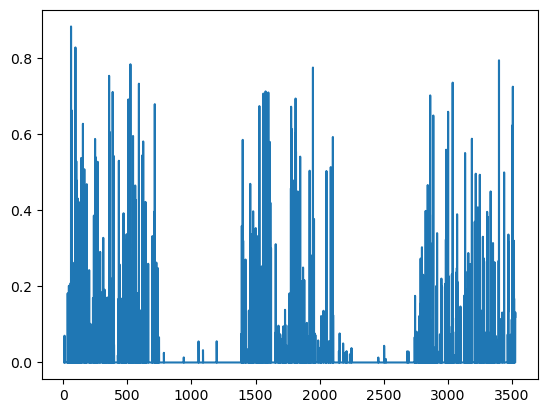

In [10]:
plt.plot(time, s)

C:\Users\aagne\AppData\Local\Temp\ipykernel_4800\2367029262.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


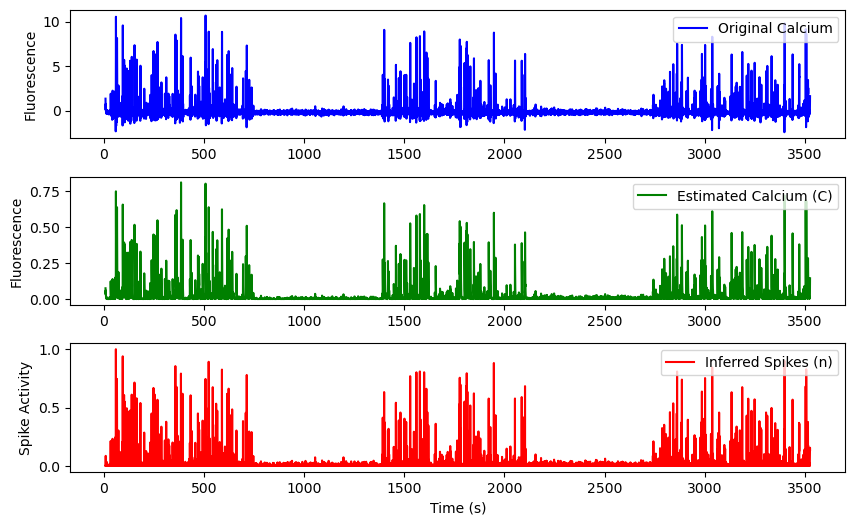

In [144]:
fig, axs = plt.subplots(
    3, 1, figsize=(10, 6), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0.3)
)

# Plot 1: Original Calcium Trace
axs[0].plot(time, example_neuron, label="Original Calcium", color="blue")
axs[0].set_ylabel("Fluorescence")
axs[0].legend(loc="upper right")
# axs[0].set_title(f"Neuron {neuron_idx} - OOPSI Results")

# Plot 2: Estimated Calcium
axs[1].plot(time, C, label="Estimated Calcium (C)", color="green")
axs[1].set_ylabel("Fluorescence")
axs[1].legend(loc="upper right")

# Plot 3: Inferred Spikes
axs[2].plot(time, n, label="Inferred Spikes (n)", color="red")
axs[2].set_ylabel("Spike Activity")
axs[2].set_xlabel("Time (s)")
axs[2].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [11]:
import numpy as np
import pandas as pd


def compute_temporal_sta(
    spike_trace,
    stim_epochs,
    stim_metadata,
    stims,
    stim_type="locally_sparse_noise",
    n_lags=10,
):
    """
    Computes spike-triggered average (STA) with time lags from probabilistic spike trace.

    Parameters:
    -----------
    spike_trace : np.ndarray
        1D array of shape (n_frames,) with continuous-valued spike likelihood.
    stim_epochs : pd.DataFrame
        DataFrame with columns ['stimulus', 'start', 'end'] for stimulus blocks.
    stim_metadata : pd.DataFrame
        DataFrame with columns ['frame', 'start', 'end'] for individual stimulus presentations.
    stims : np.ndarray
        Stimulus array of shape (n_stim_frames, dx, dy).
    stim_type : str
        Type of stimulus to compute STA over (e.g. 'locally_sparse_noise').
    n_lags : int
        Number of stimulus frames to look back in time for temporal STA.

    Returns:
    --------
    sta : np.ndarray
        Spike-triggered average of shape (n_lags, dx, dy).
    """

    # 1. Select valid epochs
    valid_epochs = stim_epochs[stim_epochs["stimulus"] == stim_type]

    # 2. Collect valid stimulus metadata rows
    valid_frames = []
    for _, row in valid_epochs.iterrows():
        start, end = row["start"], row["end"]
        valid = stim_metadata[
            (stim_metadata["start"] >= start) & (stim_metadata["end"] <= end)
        ]
        valid_frames.append(valid)
    valid_frames = pd.concat(valid_frames).reset_index(drop=True)

    # 3. Initialize accumulator
    dx, dy = stims.shape[1:]
    sta = np.zeros((n_lags, dx, dy))
    total_weight = np.zeros(n_lags)

    # 4. Loop over valid stimulus frames
    for i in range(n_lags, len(valid_frames)):
        stim_end = valid_frames.iloc[i]["end"]

        for lag in range(n_lags):
            lag_idx = i - lag
            if lag_idx < 0:
                continue

            stim_row_lag = valid_frames.iloc[lag_idx]
            frame_idx = stim_row_lag["frame"]
            stim_start = stim_row_lag["start"]

            # Compute spike count between stim_start and current stim_end
            spike_count = np.sum(spike_trace[stim_start:stim_end])

            stim_img = stims[frame_idx]
            sta[lag] += spike_count * stim_img
            total_weight[lag] += spike_count

    # 5. Normalize
    for lag in range(n_lags):
        if total_weight[lag] > 0:
            sta[lag] /= total_weight[lag]

    return sta

In [12]:
sta = compute_temporal_sta(
    spike_trace=s,
    stim_epochs=stim_epochs,
    stim_metadata=stim_metadata,
    stims=stims,
    stim_type="locally_sparse_noise",
    n_lags=6,  # For example, 15 lags (i.e., half a second if 30Hz)
)

In [114]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def animate_sta(sta, interval=100, cmap="gray", vmin=None, vmax=None, save_path=None):
    """
    Visualizes a spatio-temporal STA as an animation.

    Parameters:
    -----------
    sta : np.ndarray
        3D array of shape (n_lags, dx, dy)
    interval : int
        Delay between frames in milliseconds (default: 100ms = 10fps)
    cmap : str
        Colormap to use (e.g., 'gray', 'viridis')
    vmin, vmax : float or None
        Value limits for consistent color scaling
    save_path : str or None
        If provided, saves the animation as .mp4 or .gif

    Returns:
    --------
    ani : matplotlib.animation.FuncAnimation
        The animation object.
    """

    n_lags, dx, dy = sta.shape
    fig, ax = plt.subplots()
    ax.set_title("Spike-Triggered Average over Time Lags")
    im = ax.imshow(sta[0], cmap=cmap, vmin=vmin, vmax=vmax, interpolation="nearest")
    lag_text = ax.text(
        0.02,
        0.95,
        "",
        transform=ax.transAxes,
        color="white",
        fontsize=10,
        bbox=dict(facecolor="black", alpha=0.6, boxstyle="round"),
    )

    def update(frame):
        im.set_data(sta[frame])
        lag_text.set_text(f"Time lag: {-frame} frames")
        return [im, lag_text]

    ani = animation.FuncAnimation(
        fig, update, frames=n_lags, interval=interval, blit=True
    )

    if save_path:
        if save_path.endswith(".mp4"):
            ani.save(save_path, writer="ffmpeg")
        elif save_path.endswith(".gif"):
            ani.save(save_path, writer="pillow")
        else:
            raise ValueError("save_path must end with .mp4 or .gif")

    plt.show()
    return ani

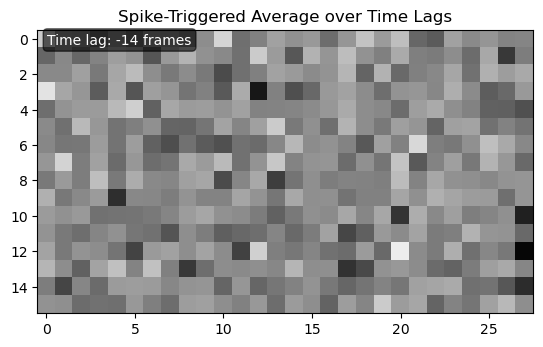

In [107]:
# Assume sta is the output from compute_temporal_sta(...)
animate_sta(sta, interval=100, cmap="gray", save_path="sta_movie.gif")

In [48]:
import matplotlib.pyplot as plt


def plot_sta_montage(sta, cmap="gray", title="STA", vmin=None, vmax=None):
    """
    Plots all STA time lags in a grid layout.
    """
    n_lags, dx, dy = sta.shape
    n_cols = int(np.ceil(np.sqrt(n_lags)))
    n_rows = int(np.ceil(n_lags / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    axes = axes.flatten()

    for i in range(n_lags):
        ax = axes[i]
        im = ax.imshow(sta[i], vmin=vmin, vmax=vmax, interpolation="bessel")
        ax.set_title(f"Lag {-i}")
        ax.axis("off")
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

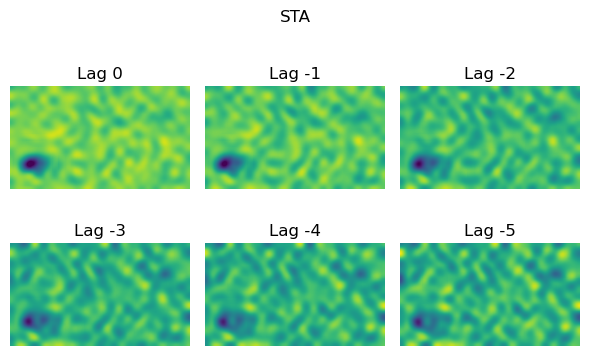

In [49]:
plot_sta_montage(sta)

## Tuning function fitting

First we'll create a dataframe combining the spikes and the stimulus information

In [150]:
# Ensure stim_metadata is sorted
stim_metadata = stim_metadata.sort_values("start").reset_index(drop=True)

# Use lsn_epochs to collect frame indices for LSN
lsn_epochs = stim_epochs[stim_epochs["stimulus"] == "locally_sparse_noise"]

lsn_frame_idxs = []
for _, row in lsn_epochs.iterrows():
    start, end = row["start"], row["end"]
    matching_frames = stim_metadata[
        (stim_metadata["start"] >= start) & (stim_metadata["end"] <= end)
    ]
    lsn_frame_idxs.extend(matching_frames["frame"].values)

lsn_frame_idxs = np.array(lsn_frame_idxs)

# Now filter stim_metadata to get just the LSN frames
stim_metadata_lsn = stim_metadata[stim_metadata["frame"].isin(lsn_frame_idxs)].copy()
stim_metadata_lsn = stim_metadata_lsn.sort_values("start").reset_index(drop=True)

# Optionally filter stims too
stims_lsn = stims[lsn_frame_idxs]


# Step 2: Define function to map spikes to stimulus frame
def map_spikes_to_frames_lsn(spikes_df, stim_metadata_lsn):
    """
    Maps each spike to the locally_sparse_noise stimulus frame active during the spike time.

    Parameters:
        spikes_df: DataFrame with spike times (columns: Neuron, TimeIdx, Time)
        stim_metadata_lsn: Only the LSN stimulus frame metadata (frame, start, end)

    Returns:
        DataFrame with matched spikes and stimulus frame info
    """
    mapped_info = []

    for _, spike in spikes_df.iterrows():
        spike_time = spike["Time"]

        # Find the LSN stimulus frame being shown during the spike
        match = stim_metadata_lsn[
            (stim_metadata_lsn["start"] <= spike_time)
            & (stim_metadata_lsn["end"] > spike_time)
        ]

        if not match.empty:
            row = match.iloc[0]
            mapped_info.append(
                {
                    "Neuron": spike["Neuron"].astype(int),
                    "Time": spike["Time"],
                    "TimeIdx": spike["TimeIdx"],
                    "StimFrameIdx": row["frame"],
                    "StimStart": row["start"],
                    "StimEnd": row["end"],
                }
            )

    return pd.DataFrame(mapped_info)

# Step 2: Define function to map spikes to stimulus frame
def map_spikes_to_frames_single_neuron(spikes, stim_metadata_lsn):
    """
    Maps each spike to the locally_sparse_noise stimulus frame active during the spike time.

    Parameters:
        spikes_df: DataFrame with spike times (columns: Neuron, TimeIdx, Time)
        stim_metadata_lsn: Only the LSN stimulus frame metadata (frame, start, end)

    Returns:
        DataFrame with matched spikes and stimulus frame info
    """
    mapped_info = []

    
    spike_time = spike["Time"]

        # Find the LSN stimulus frame being shown during the spike
        match = stim_metadata_lsn[
            (stim_metadata_lsn["start"] <= spike_time)
            & (stim_metadata_lsn["end"] > spike_time)
        ]

        if not match.empty:
            row = match.iloc[0]
            mapped_info.append(
                {
                    "Neuron": spike["Neuron"].astype(int),
                    "Time": spike["Time"],
                    "TimeIdx": spike["TimeIdx"],
                    "StimFrameIdx": row["frame"],
                    "StimStart": row["start"],
                    "StimEnd": row["end"],
                }
            )

    return pd.DataFrame(mapped_info)

# Step 3: Apply the function to map spikes
spike_with_frames = map_spikes_to_frames_lsn(spikes_custom, stim_metadata_lsn)

# Step 4: Convert frame index to int (for indexing into stims)
# spike_with_frames["StimFrameIdx"] = spike_with_frames["StimFrameIdx"].astype(int)

# Optional: Reset index
spike_with_frames = spike_with_frames.reset_index(drop=True)

IndentationError: unexpected indent (1904034870.py, line 81)

In [ ]:
print(spike_with_frames.head())

   Neuron        Time  TimeIdx  StimFrameIdx  StimStart  StimEnd
0       0   830.57680  25040.0            12        828      835
1       0   902.48936  27208.0            21        896      903
2       0  1059.11810  31930.0            42       1054     1061
3       0  1083.66390  32670.0            45       1077     1084
4       0  1177.07062  35486.0            58       1175     1182


Raster plot and density histograms

In [78]:
# To visualize how active each neuron is over time


def plot_raster(spikes_df):
    plt.figure(figsize=(12, 6))

    for neuron_id in np.unique(spikes_df["Neuron"]):
        neuron_spikes = spikes_df[spikes_df["Neuron"] == neuron_id]
        plt.vlines(
            neuron_spikes["Time"], neuron_id - 0.4, neuron_id + 0.4, color="black"
        )

    plt.xlabel("Time (s)")
    plt.ylabel("Neuron ID")
    plt.title("Raster Plot of Spikes (LSN)")
    plt.tight_layout()
    plt.show()


plot_raster(spike_with_frames)

NameError: name 'spike_with_frames' is not defined

In [79]:
# Which neurons spiked the most during LSN stim
import seaborn as sns


def plot_spike_counts(spikes_df):
    plt.figure(figsize=(10, 4))
    sns.countplot(data=spikes_df, x="Neuron", color="skyblue")
    plt.title("Spike Count per Neuron")
    # plt.xlabel("Neuron ID")
    plt.ylabel("Spike Count")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


plot_spike_counts(spike_with_frames)

NameError: name 'spike_with_frames' is not defined

In [ ]:
# Count number of spikes per neuron
spike_counts = spike_with_frames["Neuron"].value_counts().sort_values(ascending=False)

# Print the top 15 most active neurons
print("Top 10 most active neurons during LSN:")
print(spike_counts.head(15))

Top 10 most active neurons during LSN:
Neuron
43     227
71     207
38     200
98     184
163    184
89     180
174    176
114    166
10     163
138    131
146    116
80     110
151    106
60     102
144    102
Name: count, dtype: int64


In [80]:
# Get top
top_neurons = spike_counts.head(40)

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(top_neurons.index.astype(str), top_neurons.values, color="orange")
plt.xlabel("Neuron ID")
plt.ylabel("Number of Spikes")
plt.title("Top 10 Most Active Neurons (LSN)")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [81]:
# Compare Neurons Spiking to White vs. Black Pixels

# Choose a pixel to examine (e.g., center of stimulus)
px, py = 8, 14  # (row, col)

# Create a map from frame index → pixel value at (px, py)
pixel_value_map = {i: stims[i][px, py] for i in range(len(stims))}

# Add column to spikes dataframe
spike_with_frames["PixelValue"] = spike_with_frames["StimFrameIdx"].map(pixel_value_map)

# Filter by white or black
white_spikes = spike_with_frames[spike_with_frames["PixelValue"] == 255]
black_spikes = spike_with_frames[spike_with_frames["PixelValue"] == 0]

# Count how many times each neuron spiked during white/black pixel at (px, py)
white_counts = white_spikes["Neuron"].value_counts().sort_index()
black_counts = black_spikes["Neuron"].value_counts().sort_index()

# Combine and plot
df_compare = pd.DataFrame({"White": white_counts, "Black": black_counts}).fillna(0)

df_compare.plot(kind="bar", figsize=(12, 5))
plt.title(f"Neuron Spike Counts for White vs Black Pixel at ({px}, {py})")
plt.xlabel("Neuron ID")
plt.ylabel("Spike Count")
plt.tight_layout()
plt.show()

NameError: name 'spike_with_frames' is not defined

In [82]:
# Spike-Triggered Averages
# Which neurons are tuned to specific spatial locations


def compute_sta(spikes_df, stims, neuron_id, pre_spike_frames=1):
    """
    Compute Spike Triggered Average for one neuron.

    Parameters:
        spikes_df: DataFrame with spikes and stimulus frame indices
        stims: numpy array of stimulus frames (num_frames, H, W)
        neuron_id: int, which neuron to analyze
        pre_spike_frames: how many frames before the spike to average (default 1)

    Returns:
        sta: average stimulus preceding spikes, shape (H, W)
    """
    # Get spike-related stimulus frames for this neuron
    neuron_spikes = spikes_df[spikes_df["Neuron"] == neuron_id]
    frame_indices = neuron_spikes["StimFrameIdx"].values

    # Collect stimulus frames preceding spikes
    valid_frames = frame_indices[
        frame_indices >= pre_spike_frames
    ]  # avoid negative indexing
    stim_snippets = []

    for fidx in valid_frames:
        # Take the stimulus frame just before the spike frame
        stim_snippets.append(stims[fidx - pre_spike_frames])

    if len(stim_snippets) == 0:
        print(f"No spikes with valid preceding frames for neuron {neuron_id}")
        return None

    sta = np.mean(stim_snippets, axis=0)
    return sta

In [83]:
num_neurons = spike_with_frames["Neuron"].nunique()

# Compute STA for all neurons
# stas = []
# for neuron in range(num_neurons):
#     sta = compute_sta(spike_with_frames, stims, neuron)
#     stas.append(sta)

# Plot the STA for the first 9 neurons in a grid
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    if i < num_neurons and stas[i] is not None:
        ax.imshow(stas[i], cmap="gray")
        ax.set_title(f"Neuron {i}")
        ax.axis("off")
    else:
        ax.axis("off")

plt.suptitle("Spike Triggered Averages (STA) for Neurons")
plt.tight_layout()
plt.show()

NameError: name 'spike_with_frames' is not defined

## RF with lnp, bad perfromance

In [50]:
from scipy.optimize import minimize


def compute_spike_counts_from_trace(spike_trace, stim_metadata, valid_frame_indices):
    """
    Computes spike likelihood per stimulus frame using average over that frame's duration.
    """
    spike_counts = []
    for idx in valid_frame_indices:
        start = stim_metadata.iloc[idx]["start"]
        end = stim_metadata.iloc[idx]["end"]
        avg_spike = np.sum(spike_trace[start:end])
        spike_counts.append(avg_spike)
    return np.array(spike_counts)

In [51]:
def fit_receptive_field_lnp(spike_counts, stims, lags):
    """
    Fit spatiotemporal LNP receptive field using given lag structure.

    Parameters:
    -----------
    spike_counts : np.ndarray
        Array of shape (n_frames,) with weighted spike count per stimulus frame.
    stims : np.ndarray
        Stimulus array of shape (n_frames, Dx, Dy)
    lags : list or array
        List of lags (integers), e.g., [0,1,2,3,4]

    Returns:
    --------
    w_hat : np.ndarray
        Estimated receptive field weights of shape (Dx, Dy, n_lags)
    """

    Dx, Dy = stims.shape[1:]
    n_frames = stims.shape[0]
    n_lags = len(lags)

    stim_reshaped = stims.reshape(n_frames, Dx * Dy).T  # shape: (pixels, time)
    w_hat = np.zeros((Dx * Dy, n_lags))

    for i, lag in enumerate(lags):
        if lag > 0:
            s_lag = stim_reshaped[:, :-lag]  # shape: (pixels, time-lag)
            c_lag = spike_counts[lag:]  # shape: (time-lag,)
        else:
            s_lag = stim_reshaped
            c_lag = spike_counts

        def negloglike(w):
            lam = np.exp(s_lag.T @ w)
            return -np.sum(c_lag * np.log(lam + 1e-8) - lam)

        def dnegloglike(w):
            lam = np.exp(s_lag.T @ w)
            return s_lag @ (lam - c_lag)

        w0 = np.random.randn(Dx * Dy) * 0.01
        res = minimize(negloglike, w0, jac=dnegloglike, method="BFGS")
        w_hat[:, i] = res.x

    return w_hat.reshape(Dx, Dy, n_lags)

In [52]:
# --- Filter stim_epochs to include only locally_sparse_noise
lsn_epochs = stim_epochs[stim_epochs["stimulus"] == "locally_sparse_noise"]

# --- Get valid stim_metadata indices that fall within those epochs
valid_indices = []
for _, row in lsn_epochs.iterrows():
    start, end = row["start"], row["end"]
    valid = stim_metadata[
        (stim_metadata["start"] >= start) & (stim_metadata["end"] <= end)
    ]
    valid_indices.extend(valid.index.tolist())

# --- Get spike weights for each valid stimulus frame
spike_counts = compute_spike_counts_from_trace(s, stim_metadata, valid_indices)

# --- Get corresponding stims
stims_subset = stims[valid_indices]

# --- Fit LNP receptive field
lags = [0, 1, 2, 3, 4, 5]
rf = fit_receptive_field_lnp(spike_counts, stims_subset, lags)  # shape (Dx, Dy, n_lags)

C:\Users\aagne\AppData\Local\Temp\ipykernel_11324\3745959802.py:36: RuntimeWarning: overflow encountered in exp
  lam = np.exp(s_lag.T @ w)
C:\Users\aagne\AppData\Local\Temp\ipykernel_11324\3745959802.py:37: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(c_lag * np.log(lam + 1e-8) - lam)
C:\Users\aagne\AppData\Local\Temp\ipykernel_11324\3745959802.py:37: RuntimeWarning: invalid value encountered in subtract
  return -np.sum(c_lag * np.log(lam + 1e-8) - lam)
C:\Users\aagne\AppData\Local\Temp\ipykernel_11324\3745959802.py:40: RuntimeWarning: overflow encountered in exp
  lam = np.exp(s_lag.T @ w)
C:\Users\aagne\AppData\Local\Temp\ipykernel_11324\3745959802.py:41: RuntimeWarning: invalid value encountered in matmul
  return s_lag @ (lam - c_lag)
C:\Users\aagne\AppData\Local\Temp\ipykernel_11324\3745959802.py:36: RuntimeWarning: overflow encountered in exp
  lam = np.exp(s_lag.T @ w)
C:\Users\aagne\AppData\Local\Temp\ipykernel_11324\3745959802.py:37: RuntimeWarning:

In [53]:
def plot_rf(rf, cmap="bwr", title="Receptive Field", vmin=None, vmax=None):
    """
    Plots the spatiotemporal receptive field with a shared colorbar.

    Parameters:
    -----------
    rf : np.ndarray
        Receptive field of shape (Dx, Dy, n_lags)
    cmap : str
        Colormap (default: "bwr" for bipolar weights)
    title : str
        Title of the figure
    vmin, vmax : float or None
        Color limits. If None, will auto-scale.
    """
    n_lags = rf.shape[-1]
    fig, axs = plt.subplots(1, n_lags, figsize=(n_lags * 3, 3), constrained_layout=True)
    vmin = vmin if vmin is not None else np.min(rf)
    vmax = vmax if vmax is not None else np.max(rf)

    im_list = []
    for i in range(n_lags):
        im = axs[i].imshow(rf[:, :, i], interpolation="bessel")
        axs[i].set_title(f"Lag {-i}")
        axs[i].axis("off")
        im_list.append(im)

    # Create a colorbar on the right side
    cbar = fig.colorbar(im_list[0], ax=axs, orientation="vertical", shrink=0.8)
    cbar.set_label("Filter weight")
    fig.suptitle(title)
    plt.show()

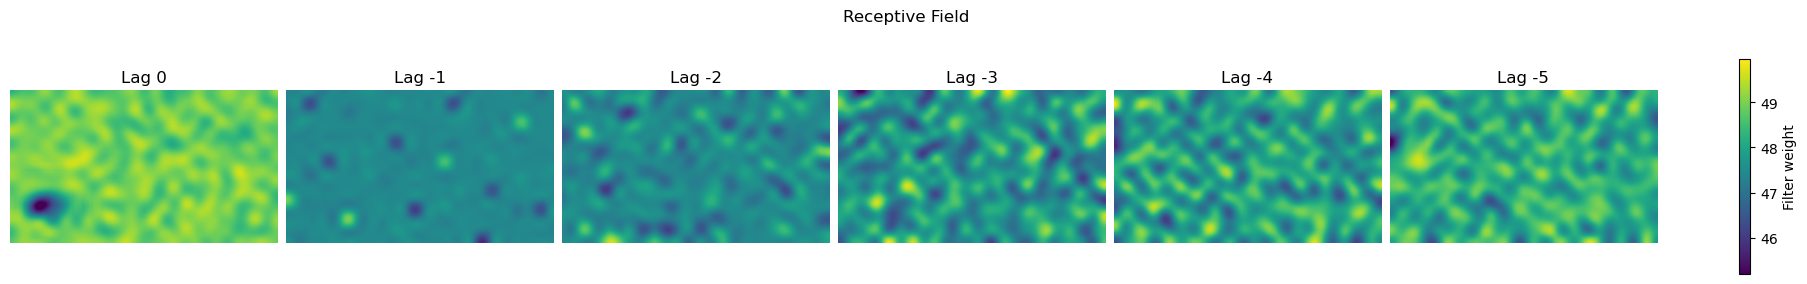

In [54]:
plot_rf(rf)

In [55]:
Dx, Dy = stims.shape[1:]
w_hat = rf.reshape(Dx * Dy, rf.shape[2])
W = w_hat - np.mean(w_hat, axis=1, keepdims=True)

# Step 2: SVD
U, S, VT = np.linalg.svd(W, full_matrices=False)

# Step 3: First spatial and temporal components
u1 = U[:, 0]  # shape: (300,)
v1 = VT[0, :]  # shape: (5,)
u1_img = u1.reshape(Dx, Dy)

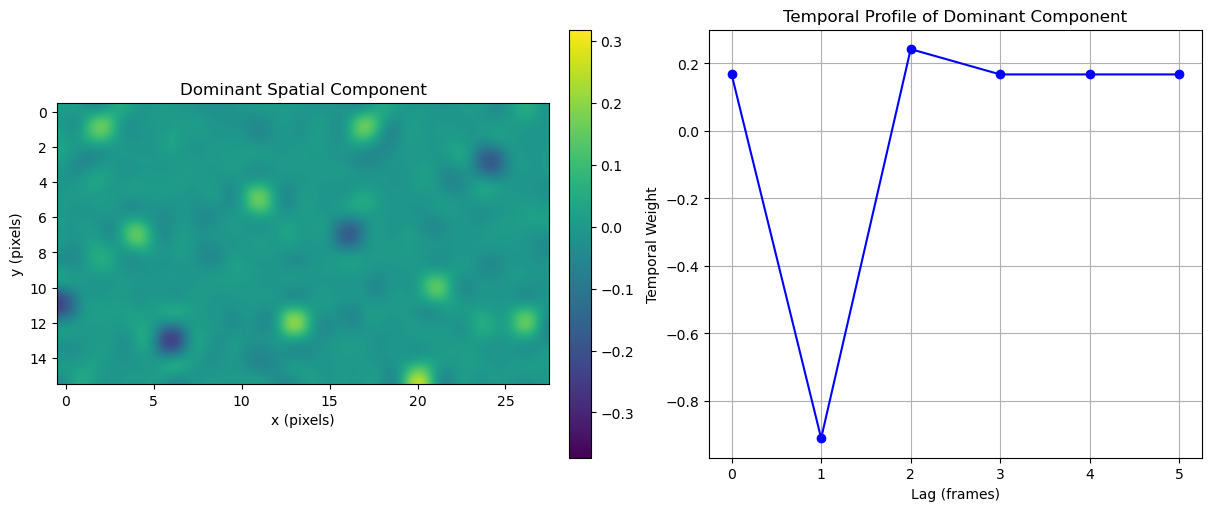

In [56]:
import matplotlib.pyplot as plt

fig, ax = plt.subplot_mosaic(
    [["Spatial", "Temporal"]], figsize=(12, 5), constrained_layout=True
)

# Plot spatial component (reshaped)
vlim = np.max(np.abs(u1_img))
im = ax["Spatial"].imshow(u1_img, interpolation="bessel")
ax["Spatial"].set_title("Dominant Spatial Component")
ax["Spatial"].set_xlabel("x (pixels)")
ax["Spatial"].set_ylabel("y (pixels)")
fig.colorbar(im, ax=ax["Spatial"], fraction=0.046, pad=0.04)

# Plot temporal component
ax["Temporal"].plot(lags, v1, marker="o", color="blue")
ax["Temporal"].set_title("Temporal Profile of Dominant Component")
ax["Temporal"].set_xlabel("Lag (frames)")
ax["Temporal"].set_ylabel("Temporal Weight")
ax["Temporal"].grid(True)

plt.show()

NameError: name 'w_hat_reshaped' is not defined

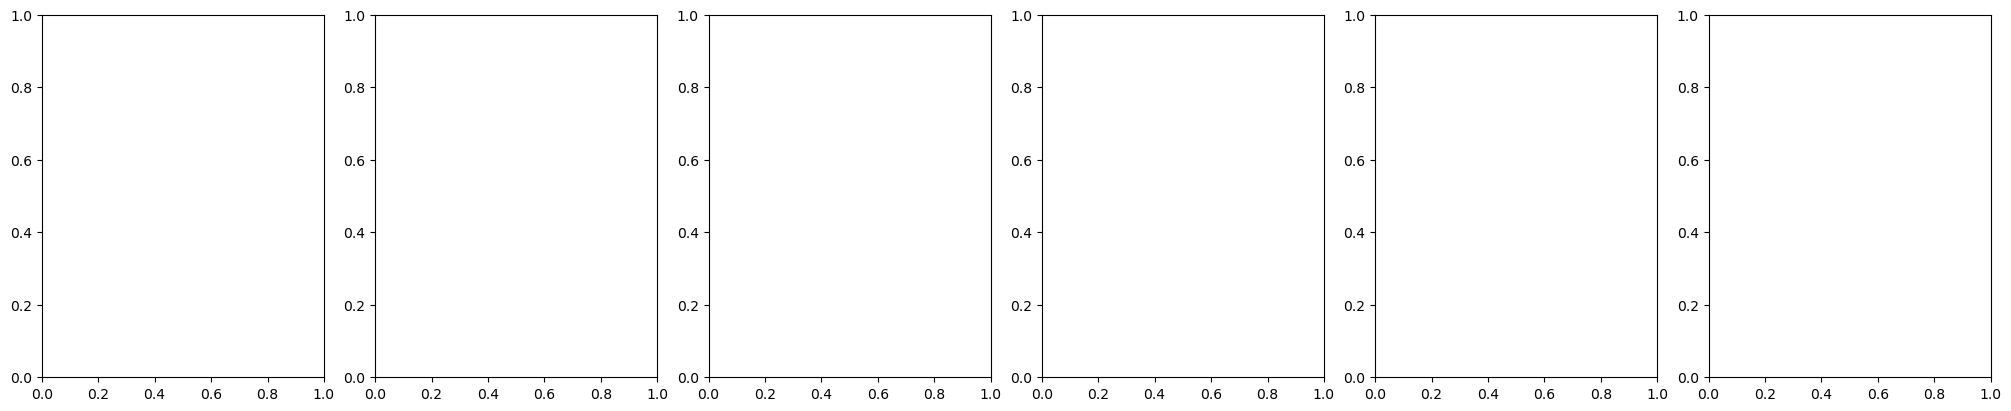

In [94]:
# Plot all RF lags
fig, ax = plt.subplot_mosaic([lags], figsize=(20, 4), constrained_layout=True)

for i, lag in enumerate(lags):
    vmin, vmax = np.percentile(w_hat_reshaped[:, :, i], [2, 98])
    im = ax[lag].imshow(w_hat_reshaped[:, :, i], cmap="bwr", vmin=vmin, vmax=vmax)
    ax[lag].set_title(f"Lag {lag}")
    ax[lag].axis("off")
    fig.colorbar(im, ax=ax[lag], fraction=0.046, pad=0.04)

plt.suptitle(f"Estimated Receptive Field (Neuron {neuron_id})", fontsize=16)
plt.show()

## RF with Berens Library

In [61]:
from rfest import splineLG, splineLNP, splineLNLN
from rfest.utils import fetch_data, split_data, upsample_data
from rfest.utils import get_n_samples, build_design_matrix

In [ ]:
dims = [Dx, Dy]
df = [int(np.maximum(np.ceil(dim / 2), 3)) for dim in list(dims)]

In [ ]:
import numpy as np
import pandas as pd


def build_stimulus_matrix(stims, stim_epochs, stim_metadata, trace_length):
    """
    Builds stimulus matrix `s` of shape (Dx * Dy, nT), where each column is the stimulus
    shown at that timepoint, or zeros if no stimulus was shown.

    Parameters:
        stims: np.array of shape (9000, Dx, Dy)
        stim_epochs: pd.DataFrame with 'stimulus', 'start', 'end'
        stim_metadata: pd.DataFrame with 'frame', 'start', 'end'
        trace_length: int, number of timepoints in spike train

    Returns:
        s: np.array of shape (Dx*Dy, nT)
    """

    Dx, Dy = stims.shape[1], stims.shape[2]
    nT = trace_length
    s = np.zeros((nT, Dx, Dy), dtype=stims.dtype)

    # Filter epochs for locally sparse noise
    lsn_epochs = stim_epochs[stim_epochs["stimulus"] == "locally_sparse_noise"]

    # Flatten each stim frame once
    flat_stims = stims.reshape(stims.shape[0], -1)  # shape (9000, Dx*Dy)

    # Loop through all metadata rows and check if the frame belongs to LSN
    for _, row in stim_metadata.iterrows():
        frame = row["frame"]
        t_start = int(row["start"])
        t_end = int(row["end"])

        # Check if this frame falls within any LSN epoch
        in_lsn = any(
            (t_start >= epoch_start) and (t_end <= epoch_end)
            for epoch_start, epoch_end in zip(lsn_epochs["start"], lsn_epochs["end"])
        )
        if in_lsn and frame < len(flat_stims):
            # Fill in the same stimulus vector across the time window
            s[t_start:t_end, :] = stims[frame]
            # [:, np.newaxis]
    s = s.reshape(nT, Dx, Dy)
    return s

In [96]:
trace_length = len(s)
stims_valid = build_stimulus_matrix(stims, stim_epochs, stim_metadata, trace_length)

In [97]:
stims_valid.shape

(105968, 16, 28)

In [111]:
n_stim = stims_valid.shape[0]
X = build_design_matrix(stims_valid.reshape((n_stim, -1)), 1)
y = s
df = [12, 24]
model = splineLNP(X, y, dims=[Dx, Dy], dt=dt, df=df, compute_mle=True)
model.fit(verbose=0, fit_nonlinearity=True)

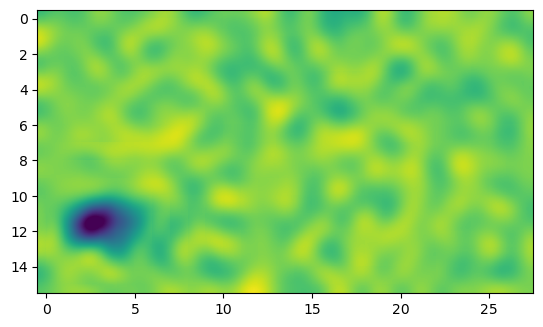

In [112]:
for key, w in model.__dict__.items():
    if "w_" in key:
        try:

            plt.imshow(w.reshape(dims), interpolation="bessel")

        except:
            continue